## Applying k-NN for STLF

Traditionally, kNN is used for *regression* and *classification*, but we can adopt it for time-series analysis. See [here](https://people.revoledu.com/kardi/tutorial/KNN/KNN_TimeSeries.htm).

The approach is as follows for a single-variable case, such as temperature:Given a dataset $D$, we identify the k-nearest temperature points that are closest to the current temperature. We then compute the average of the corresponding demand values associated with these k temperature points. This averaged demand serves as our prediction of interest.



There are certain choices that we must confront when applying kNN for STLF. Firstly, in the features found in our dataset, the features `weekend` and `holiday` are binary. On the other hand, the features `hourOfDay`, `T2M_toc` and `hourOfDay` are continious. It is crucial to address the potential variance arising from this mix of binary and continuous features. See the discussion [here](https://stats.stackexchange.com/questions/271043/k-nearest-neighbour-with-continuous-and-binary-variables)

One approach is that we **scale** all variables between 0 and 1. However, the problem is that binary variables will have greater influence on the nearest neighbors in KNN compared to scaled real-value variables (out of the total distance between 1 and 0, for binary variable the distance is always 1 so the distance is always maximized). The performance of our algo would be sensitive and dependent upon the **type of scaling**. We would use the following 2 scaling:
1. Min-Max Scaling
2. Z-Score Normalization

Furthermore, we would explore the following metrics:
1. Manhatten
2. Euclidean
3. Dynamic Time Warping (To be discussed in the next notebook)

We will aim to perform k-NN using the following outline:
1. **Current Features**: `dayOfWeek`, `weekend`,  `Holiday_ID`, `hourOfDay`, `T2M_toc`
2. **Lag Features**: `week_X-2`, `week_X-3`, `week_X-4`, `MA_X-4`
3. **Combined Features**: Lag Features + Current Features






In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_path = "/content/drive/My Drive/Datasets/Panama_Dataset/train_dataframes.xlsx"
test_path = "/content/drive/My Drive/Datasets/Panama_Dataset/test_dataframes.xlsx"


In [ ]:
train_dict = pd.read_excel(open(train_path, 'rb'), sheet_name=None, index_col=0)
test_dict = pd.read_excel(open(test_path, 'rb'), sheet_name=None, index_col=0)

# Experiment with a single-train test split

In [ ]:
keys = list(train_dict.keys())
train = train_dict[keys[0]]
test = test_dict[keys[0]]

In [ ]:
selected_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc','week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4','DEMAND']
train = pd.DataFrame(train, columns=train.columns)[selected_features]
test = pd.DataFrame(test, columns=test.columns)[selected_features]

current_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc']
lag_features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4']
combined_features = current_features + lag_features
y_feature = ['DEMAND']

x_current_train = pd.DataFrame(train, columns=train.columns)[current_features]
x_current_test = pd.DataFrame(test, columns=train.columns)[current_features]

x_lag_train = pd.DataFrame(train, columns=train.columns)[lag_features]
x_lag_test = pd.DataFrame(test, columns=train.columns)[lag_features]

x_combined_train = pd.DataFrame(train, columns=train.columns)[combined_features]
x_combined_test = pd.DataFrame(test, columns=train.columns)[combined_features]

y_train = pd.DataFrame(train, columns=test.columns)[y_feature]
y_test = pd.DataFrame(test, columns=test.columns)[y_feature]

### Feature Scaling

MinMaxScaler scales the data between 0 and 1

In [ ]:
scaler = MinMaxScaler()

x_current_train_scaled = scaler.fit_transform(x_current_train)
x_current_test_scaled = scaler.transform(x_current_test)

x_lag_train_scaled = scaler.fit_transform(x_lag_train)
x_lag_test_scaled = scaler.transform(x_lag_test)

x_combined_train_scaled = scaler.fit_transform(x_combined_train)
x_combined_test_scaled = scaler.transform(x_combined_test)

x_current_train_scaled = pd.DataFrame(x_current_train_scaled, columns=x_current_train.columns, index=train.index)
x_current_test_scaled = pd.DataFrame(x_current_test_scaled, columns=x_current_test.columns, index=test.index)

x_lag_train_scaled = pd.DataFrame(x_lag_train_scaled, columns=x_lag_train.columns, index=train.index)
x_lag_test_scaled = pd.DataFrame(x_lag_test_scaled, columns=x_lag_test.columns, index=test.index)

x_combined_train_scaled = pd.DataFrame(x_combined_train_scaled, columns=x_combined_train.columns, index=train.index)
x_combined_test_scaled = pd.DataFrame(x_combined_test_scaled, columns=x_combined_test.columns, index=test.index)

In [ ]:
k_values = [1,2, 3, 4, 5, 6, 7, 8, 9]
mse_values_manhattan = []
mse_values_euclidean = []

def run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric='manhattan'):
    mse_values = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
        knn.fit(x_train, y_train)
        predicted_labels = knn.predict(x_test)
        mse = mean_squared_error(y_test, predicted_labels)
        mse_values.append(mse)

    return mse_values

#lets create a generalized function to return the best value of k and also plot MSE with various values of k.

def run_knn_experiment(k_values, x_train, y_train, x_test, y_test, metric='manhattan'): #using manhatten as default parameter
    mse_values = run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric=metric)

    min_mse = min(mse_values) #finding the minimum value of mse
    index = mse_values.index(min_mse)
    best_k = k_values[index] #finding the associated index with that value

    plt.plot(k_values, mse_values, marker='o', label=f'{metric.capitalize()}')

    return min_mse, best_k

### Plotting the Best Results for first train-test:


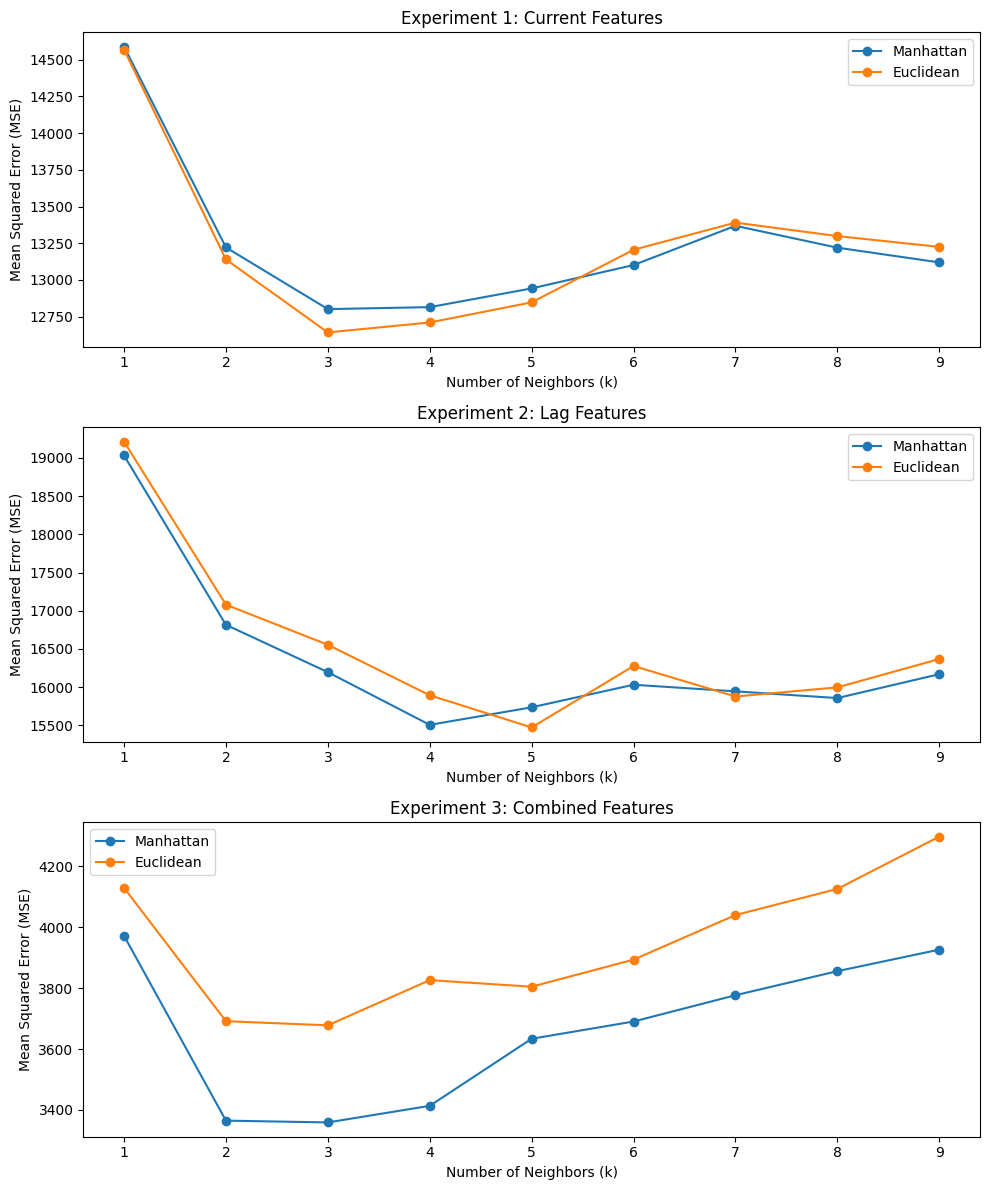

In [ ]:

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.title('Experiment 1: Current Features')
min_mse_current_manhattan, best_k_current_manhattan = run_knn_experiment(
    k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='manhattan'
)
min_mse_current_euclidean, best_k_current_euclidean = run_knn_experiment(
    k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='euclidean'
)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Experiment 2: Lag Features')
min_mse_lag_manhattan, best_k_lag_manhattan = run_knn_experiment(
    k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='manhattan'
)
min_mse_lag_euclidean, best_k_lag_euclidean = run_knn_experiment(
    k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='euclidean'
)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Experiment 3: Combined Features')
min_mse_combined_manhattan, best_k_combined_manhattan = run_knn_experiment(
    k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='manhattan'
)
min_mse_combined_euclidean, best_k_combined_euclidean = run_knn_experiment(
    k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='euclidean'
)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print("Min MSE (Current - Manhattan):", min_mse_current_manhattan)
print("Best k:", best_k_current_manhattan)
print("Min MSE (Current - Euclidean):", min_mse_current_euclidean)
print("Best k:", best_k_current_euclidean)
print("Min MSE (Lag - Manhattan):", min_mse_lag_manhattan)
print("Best k:", best_k_lag_manhattan)
print("Min MSE (Lag - Euclidean):", min_mse_lag_euclidean)
print("Best k:", best_k_lag_euclidean)
print("Min MSE (Combined - Manhattan):", min_mse_combined_manhattan)
print("Best k:", best_k_combined_manhattan)
print("Min MSE (Combined - Euclidean):", min_mse_combined_euclidean)
print("Best k:", best_k_combined_euclidean)

Min MSE (Current - Manhattan): 12801.403211982773
Best k: 3
Min MSE (Current - Euclidean): 12642.476005392642
Best k: 3
Min MSE (Lag - Manhattan): 15507.523313563774
Best k: 4
Min MSE (Lag - Euclidean): 15473.769664338683
Best k: 5
Min MSE (Combined - Manhattan): 3358.7641979079863
Best k: 3
Min MSE (Combined - Euclidean): 3677.762746793566
Best k: 3


### Evaluation

Based on these results, we see that the best hyperparameters using are the following:

- For current features  
  - *Metric:* Euclidean  
  - *Value of K:* 3  
- For lag features  
  - *Metric:* Manhattan  
  - *Value of K:* 4  
- For combined features  
  - *Metric:* Manhattan  
  - *Value of K:* 3  

### Plotting Predicted vs Actuals for first training-test split:

Lets use these hyperparameters to see how KNN perform for the first training-test split. We first extract out the predicted labels that these best hyperparameters give and then we plot the results.

### Extracting Labels


In [ ]:
def train_and_predict_knn(x_train, y_train, x_test, k, metric='manhattan'):
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn.fit(x_train, y_train.values.ravel())
    predicted_labels = knn.predict(x_test)
    return predicted_labels


# Experiment 1: Current
predicted_labels_current_euclidean = train_and_predict_knn(x_current_train_scaled, y_train, x_current_test_scaled, best_k_current_euclidean, metric='euclidean')

# Experiment 2: Lag
predicted_labels_lag_manhattan = train_and_predict_knn(x_lag_train_scaled, y_train, x_lag_test_scaled, best_k_lag_manhattan, metric='manhattan')

# Experiment 3: Combined
predicted_labels_combined_manhattan = train_and_predict_knn(x_combined_train_scaled, y_train, x_combined_test_scaled, best_k_combined_manhattan, metric='manhattan')

### Plotting

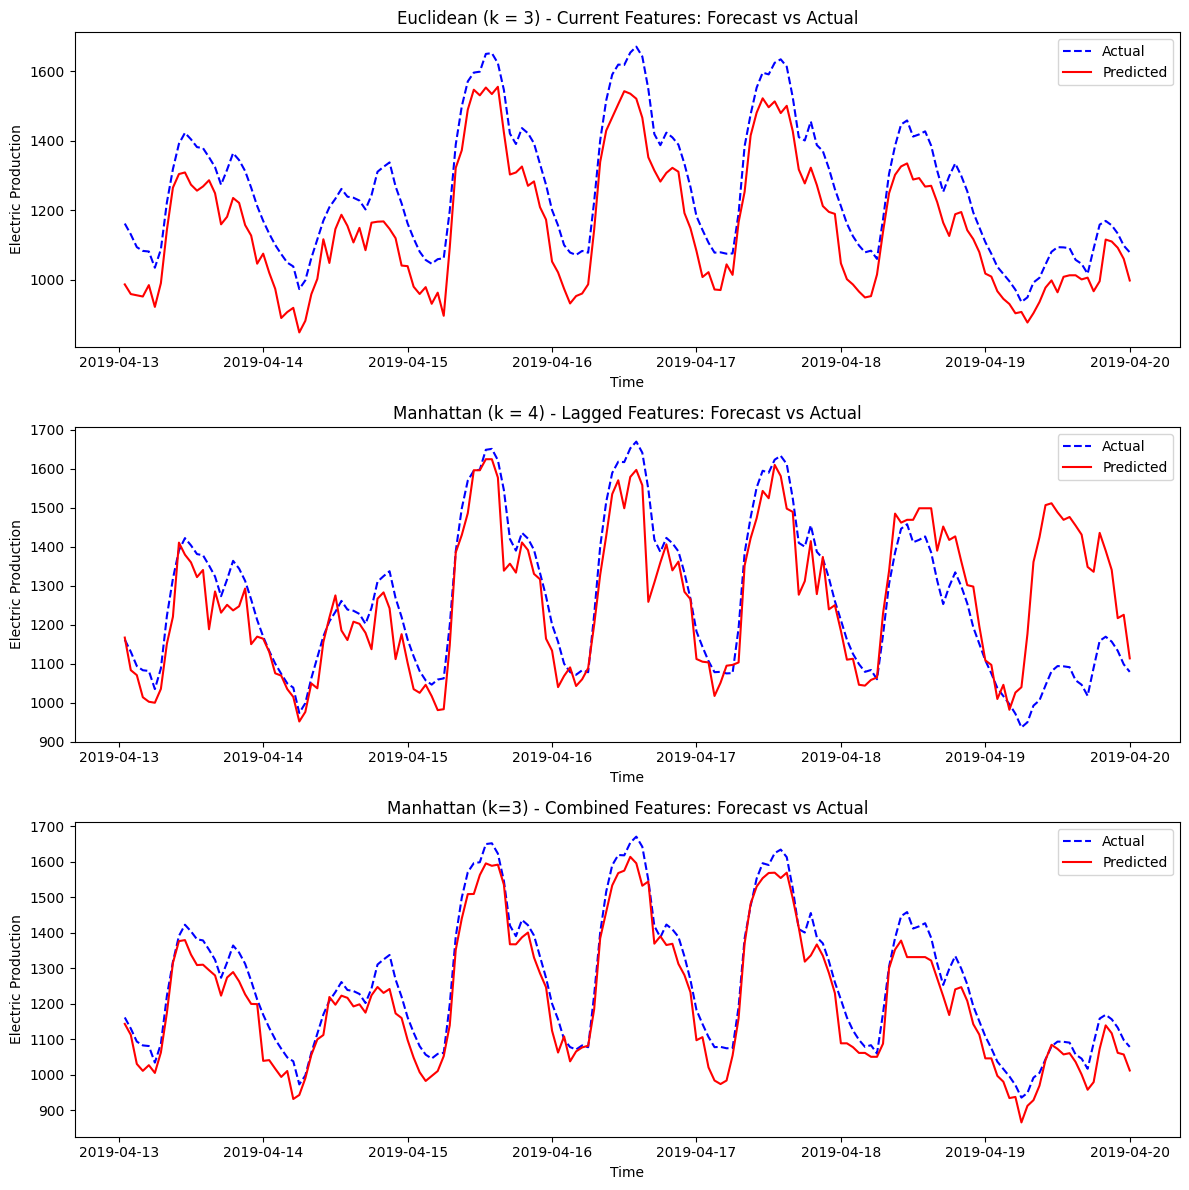

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(y_test.index, y_test, label='Actual', linestyle='dashed', color='b')
plt.plot(y_test.index, predicted_labels_current_euclidean, label='Predicted', color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Euclidean (k = 3) - Current Features: Forecast vs Actual')

plt.subplot(3, 1, 2)
plt.plot(y_test.index, y_test, label='Actual', linestyle='dashed', color='b')
plt.plot(y_test.index, predicted_labels_lag_manhattan, label='Predicted', color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Manhattan (k = 4) - Lagged Features: Forecast vs Actual')

plt.subplot(3, 1, 3)
plt.plot(y_test.index, y_test, label='Actual', linestyle='dashed', color='b')
plt.plot(y_test.index, predicted_labels_combined_manhattan, label='Predicted', color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Electric Production')
plt.title('Manhattan (k=3) - Combined Features: Forecast vs Actual')

plt.tight_layout()
plt.show()

### Evaluating all the loss functions for single-test train split:

From the results below, it is evident that **combined features** work the best on accuracy.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    return rmse


def peak_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_load_true = np.max(y_true)
    plape = np.abs((peak_load_true - np.max(y_pred)) / peak_load_true) * 100
    return plape

def value_load_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    peak_min_true = np.min(y_true)
    vlape = np.abs((peak_min_true - np.min(y_pred)) / peak_min_true) * 100
    return vlape


def energy_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_energy_true = np.sum(y_true)
    total_energy_pred = np.sum(y_pred)
    eape = np.abs((total_energy_true - total_energy_pred) / total_energy_true) * 100

    return eape

In [ ]:
predicted_df_cur = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_current_euclidean}, index=y_test.index)
predicted_df_lag = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_lag_manhattan}, index=y_test.index)
predicted_df_comb = pd.DataFrame({'Predicted_Labels_Manhattan': predicted_labels_combined_manhattan}, index=y_test.index)

mape_cur = mean_absolute_percentage_error(y_test, predicted_df_cur)
rmse_cur = root_mean_squared_error(y_test, predicted_df_cur)
plape_cur = peak_load_absolute_percentage_error(y_test, predicted_df_cur)
vlape_cur = value_load_absolute_percentage_error(y_test, predicted_df_cur)
eape_cur = energy_absolute_percentage_error(y_test, predicted_df_cur)


mape_lag = mean_absolute_percentage_error(y_test, predicted_df_lag)
rmse_lag = root_mean_squared_error(y_test, predicted_df_lag)
plape_lag = peak_load_absolute_percentage_error(y_test, predicted_df_lag)
vlape_lag = value_load_absolute_percentage_error(y_test, predicted_df_lag)
eape_lag = energy_absolute_percentage_error(y_test, predicted_df_lag)


mape_comb = mean_absolute_percentage_error(y_test, predicted_df_comb)
rmse_comb = root_mean_squared_error(y_test, predicted_df_comb)
plape_comb = peak_load_absolute_percentage_error(y_test, predicted_df_comb)
vlape_comb = value_load_absolute_percentage_error(y_test, predicted_df_comb)
eape_comb = energy_absolute_percentage_error(y_test, predicted_df_comb)

metrics_df = pd.DataFrame({
    "Feature Set": ["Current Features", "Lagged Features", "Combined Features"],
    "MAPE": [mape_cur, mape_lag, mape_comb],
    "RMSE": [rmse_cur, rmse_lag, rmse_comb],
    "PLAPE": [plape_cur, plape_lag, plape_comb],
    "VLAPE": [vlape_cur, vlape_lag, vlape_comb],
    "EAPE": [eape_cur, eape_lag, eape_comb]
})

display(metrics_df)


,Feature Set,MAPE,RMSE,PLAPE,VLAPE,EAPE
0,Current Features,8.53,112.438766,6.911639,9.345021,8.421885
1,Lagged Features,6.77,124.529207,2.703699,1.626801,0.201854
2,Combined Features,4.00,57.954846,3.402547,7.452316,3.909838


# Experiment with the entire Dataset:

In [ ]:
def run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric='manhattan'):
    mse_values = []

    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
        knn.fit(x_train, y_train)
        predicted_labels = knn.predict(x_test)
        mse = mean_squared_error(y_test, predicted_labels)
        mse_values.append(mse)

    return mse_values


def run_knn_experiment(k_values, x_train, y_train, x_test, y_test, metric='manhattan'): #using manhatten as default parameter
    mse_values = run_knn_with_metrics(k_values, x_train, y_train, x_test, y_test, metric=metric)

    min_mse = min(mse_values) #finding the minimum value of mse
    index = mse_values.index(min_mse)
    best_k = k_values[index] #finding the associated index with that value

    return min_mse, best_k


best_current_man = []
best_current_euc = []

best_lagged_man = []
best_lagged_euc = []

best_combined_man = []
best_combined_euc = []


for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    selected_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc','week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4','DEMAND']
    train = pd.DataFrame(train, columns=train.columns)[selected_features]
    test = pd.DataFrame(test, columns=test.columns)[selected_features]

    current_features = ['dayOfWeek', 'weekend', 'holiday', 'hourOfDay', 'T2M_toc']
    lag_features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4']
    combined_features = current_features + lag_features
    y_feature = ['DEMAND']

    x_current_train = pd.DataFrame(train, columns=train.columns)[current_features]
    x_current_test = pd.DataFrame(test, columns=train.columns)[current_features]

    x_lag_train = pd.DataFrame(train, columns=train.columns)[lag_features]
    x_lag_test = pd.DataFrame(test, columns=train.columns)[lag_features]

    x_combined_train = pd.DataFrame(train, columns=train.columns)[combined_features]
    x_combined_test = pd.DataFrame(test, columns=train.columns)[combined_features]

    y_train = pd.DataFrame(train, columns=test.columns)[y_feature]
    y_test = pd.DataFrame(test, columns=test.columns)[y_feature]

    scaler = MinMaxScaler()

    x_current_train_scaled = scaler.fit_transform(x_current_train)
    x_current_test_scaled = scaler.transform(x_current_test)

    x_lag_train_scaled = scaler.fit_transform(x_lag_train)
    x_lag_test_scaled = scaler.transform(x_lag_test)

    x_combined_train_scaled = scaler.fit_transform(x_combined_train)
    x_combined_test_scaled = scaler.transform(x_combined_test)

    x_current_train_scaled = pd.DataFrame(x_current_train_scaled, columns=x_current_train.columns, index=train.index)
    x_current_test_scaled = pd.DataFrame(x_current_test_scaled, columns=x_current_test.columns, index=test.index)

    x_lag_train_scaled = pd.DataFrame(x_lag_train_scaled, columns=x_lag_train.columns, index=train.index)
    x_lag_test_scaled = pd.DataFrame(x_lag_test_scaled, columns=x_lag_test.columns, index=test.index)

    x_combined_train_scaled = pd.DataFrame(x_combined_train_scaled, columns=x_combined_train.columns, index=train.index)
    x_combined_test_scaled = pd.DataFrame(x_combined_test_scaled, columns=x_combined_test.columns, index=test.index)

    man_best_cur = run_knn_experiment(k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='manhattan')
    euc_best_cur = run_knn_experiment(k_values, x_current_train_scaled, y_train, x_current_test_scaled, y_test, metric='euclidean')

    best_current_man.append(man_best_cur)
    best_current_euc.append(euc_best_cur)

    best_lag_cur = run_knn_experiment(k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='manhattan')
    best_lag_euc = run_knn_experiment(k_values, x_lag_train_scaled, y_train, x_lag_test_scaled, y_test, metric='euclidean')

    best_lagged_man.append(best_lag_cur)
    best_lagged_euc.append(best_lag_euc)

    comb_man = run_knn_experiment(k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='manhattan')
    comb_euc = run_knn_experiment(k_values, x_combined_train_scaled, y_train, x_combined_test_scaled, y_test, metric='euclidean')

    best_combined_man.append(comb_man)
    best_combined_euc.append(comb_euc)



print(best_current_man) # best value of k comes out to be 9
print(best_current_euc) # best value of k comes out to be 9
print(best_lagged_man) # best value of k comes out to be 9
print(best_lagged_euc)# best value of k comes out to be 9
print(best_combined_man) # best value of k comes out to be 9
print(best_combined_euc) # best value of k comes out to be 9

[(12346.533671696863, 3), (8241.628935444038, 9), (17388.135649701588, 8), (7165.208403439441, 6), (4726.1012506613915, 9), (2693.183962881016, 8), (1439.9435320123548, 9), (3455.8396624377046, 9), (14596.385690297033, 8), (6384.27550119587, 9), (10872.893484663555, 8), (9088.19891979582, 9), (29999.44908235691, 6), (19951.643627290992, 8)]
[(12289.670584614945, 3), (8241.628935444038, 9), (17385.603721342, 9), (7165.208403439441, 6), (4717.437363706531, 9), (2693.183962881016, 8), (1440.1145076390978, 9), (3531.192106790262, 9), (14358.824366956558, 8), (6362.071317637829, 9), (10872.893484663555, 8), (9088.19891979582, 9), (29992.883290188336, 6), (19951.643627290992, 8)]
[(15507.523313563774, 4), (3330.991325136356, 9), (13924.603195795939, 8), (5051.627652949519, 9), (5599.7503329530955, 9), (3537.8426766331386, 8), (3914.8892732962795, 9), (15717.093201775642, 8), (16306.287718379594, 2), (12069.263471362498, 9), (4117.68922884554, 9), (1725.0620920677168, 9), (5812.34830635621, 9

In [ ]:

best_current_man = np.array(best_current_man)
best_current_euc = np.array(best_current_euc)

best_lagged_man = np.array(best_lagged_man)
best_lagged_euc = np.array(best_lagged_euc)
best_combined_man = np.array(best_combined_man)
best_combined_euc = np.array(best_combined_euc)

mse_cur_man = np.mean(best_current_man, axis=0)[0]
mse_cur_euc = np.mean(best_current_euc, axis=0)[0]
mse_lagged_man = np.mean(best_lagged_man, axis=0)[0]
mse_lagged_euc = np.mean(best_lagged_euc, axis=0)[0]
mse_combined_man = np.mean(best_combined_man, axis=0)[0]
mse_combined_euc = np.mean(best_combined_euc, axis=0)[0]

print("Mean of Mse for Current Manhattan:", mse_cur_man)
print("Mean of Mse for Current Euclidean:", mse_cur_euc)
print("Mean of Mse for Lagged Manhattan:", mse_lagged_man)
print("Mean of Mse for Lagged Euclidean:", mse_lagged_euc)
print("Mean of Mse for Combined Manhattan:", mse_combined_man)
print("Mean of Mse for Combined Euclidean:", mse_combined_euc)

Mean of Mse for Current Manhattan: 10596.387240991042
Mean of Mse for Current Euclidean: 10577.896756599317
Mean of Mse for Lagged Manhattan: 7865.242080916576
Mean of Mse for Lagged Euclidean: 7874.133669488979
Mean of Mse for Combined Manhattan: 3951.9144357712285
Mean of Mse for Combined Euclidean: 4040.52168477937


## Evaluating for optimal hyperparameters (k = 9 and both metrics)

In [ ]:
def train_and_predict_knn(x_train, y_train, x_test, k, metric='manhattan'):
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn.fit(x_train, y_train.values.ravel())
    predicted_labels = knn.predict(x_test)
    return predicted_labels

best_k = 9 #this is for all of them so we need not worry.

mse_cur_man1 = []
mape_cur_man1 = []
rmse_cur_man1 = []
plape_cur_man1 = []
vlape_cur_man1 = []
eape_cur_man1 = []

mse_cur_euc1 = []
mape_cur_euc1 = []
rmse_cur_euc1 = []
plape_cur_euc1 = []
vlape_cur_euc1 = []
eape_cur_euc1 = []


mse_lag_man1 = []
mape_lag_man1 = []
rmse_lag_man1 = []
plape_lag_man1 = []
vlape_lag_man1 = []
eape_lag_man1 = []

mse_lag_euc1 = []
mape_lag_euc1 = []
rmse_lag_euc1 = []
plape_lag_euc1 = []
vlape_lag_euc1 = []
eape_lag_euc1 = []

mse_comb_man1 = []
mape_comb_man1 = []
rmse_comb_man1 = []
plape_comb_man1 = []
vlape_comb_man1 = []
eape_comb_man1 = []

mse_comb_euc1 = []
mape_comb_euc1 = []
rmse_comb_euc1 = []
plape_comb_euc1 = []
vlape_comb_euc1 = []
eape_comb_euc1 = []


for i in range(len(keys)):
    train = train_dict[keys[i]]
    test = test_dict[keys[i]]
    selected_features = ['dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc','week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4','DEMAND']
    train = pd.DataFrame(train, columns=train.columns)[selected_features]
    test = pd.DataFrame(test, columns=test.columns)[selected_features]

    current_features = ['dayOfWeek', 'weekend', 'holiday', 'hourOfDay', 'T2M_toc']
    lag_features = ['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4']
    combined_features = current_features + lag_features
    y_feature = ['DEMAND']

    x_current_train = pd.DataFrame(train, columns=train.columns)[current_features]
    x_current_test = pd.DataFrame(test, columns=train.columns)[current_features]

    x_lag_train = pd.DataFrame(train, columns=train.columns)[lag_features]
    x_lag_test = pd.DataFrame(test, columns=train.columns)[lag_features]

    x_combined_train = pd.DataFrame(train, columns=train.columns)[combined_features]
    x_combined_test = pd.DataFrame(test, columns=train.columns)[combined_features]

    y_train = pd.DataFrame(train, columns=test.columns)[y_feature]
    y_test = pd.DataFrame(test, columns=test.columns)[y_feature]

    scaler = MinMaxScaler()

    x_current_train_scaled = scaler.fit_transform(x_current_train)
    x_current_test_scaled = scaler.transform(x_current_test)

    x_lag_train_scaled = scaler.fit_transform(x_lag_train)
    x_lag_test_scaled = scaler.transform(x_lag_test)

    x_combined_train_scaled = scaler.fit_transform(x_combined_train)
    x_combined_test_scaled = scaler.transform(x_combined_test)

    x_current_train_scaled = pd.DataFrame(x_current_train_scaled, columns=x_current_train.columns, index=train.index)
    x_current_test_scaled = pd.DataFrame(x_current_test_scaled, columns=x_current_test.columns, index=test.index)

    x_lag_train_scaled = pd.DataFrame(x_lag_train_scaled, columns=x_lag_train.columns, index=train.index)
    x_lag_test_scaled = pd.DataFrame(x_lag_test_scaled, columns=x_lag_test.columns, index=test.index)

    x_combined_train_scaled = pd.DataFrame(x_combined_train_scaled, columns=x_combined_train.columns, index=train.index)
    x_combined_test_scaled = pd.DataFrame(x_combined_test_scaled, columns=x_combined_test.columns, index=test.index)

    # Experiment 1: Current
    predicted_labels_current_manhattan = train_and_predict_knn(x_current_train_scaled, y_train, x_current_test_scaled, best_k, metric='manhattan')


    predicted_labels_current_euclidean = train_and_predict_knn(x_current_train_scaled, y_train, x_current_test_scaled, best_k, metric='euclidean')


    # Experiment 2: Lag
    predicted_labels_lag_manhattan = train_and_predict_knn(x_lag_train_scaled, y_train, x_lag_test_scaled, best_k, metric='manhattan')


    predicted_labels_lag_euclidean = train_and_predict_knn(x_lag_train_scaled, y_train, x_lag_test_scaled, best_k, metric='euclidean')

    # Experiment 3: Combined
    predicted_labels_combined_manhattan = train_and_predict_knn(x_combined_train_scaled, y_train, x_combined_test_scaled, best_k, metric='manhattan')


    predicted_labels_combined_euclidean = train_and_predict_knn(x_combined_train_scaled, y_train, x_combined_test_scaled, best_k, metric='euclidean')



    mse_cur_man = mean_squared_error(y_test, predicted_labels_current_manhattan)
    mape_cur_man = mean_absolute_percentage_error(y_test, predicted_labels_current_manhattan)
    rmse_cur_man = root_mean_squared_error(y_test, predicted_labels_current_manhattan)
    plape_cur_man = peak_load_absolute_percentage_error(y_test, predicted_labels_current_manhattan)
    vlape_cur_man = value_load_absolute_percentage_error(y_test, predicted_labels_current_manhattan)
    eape_cur_man = energy_absolute_percentage_error(y_test, predicted_labels_current_manhattan)

    mse_cur_man1.append(mse_cur_man)
    mape_cur_man1.append(mape_cur_man)
    rmse_cur_man1.append(rmse_cur_man)
    plape_cur_man1.append(plape_cur_man)
    vlape_cur_man1.append(vlape_cur_man)
    eape_cur_man1.append(eape_cur_man)

    mse_cur_euc = mean_squared_error(y_test, predicted_labels_current_euclidean)
    mape_cur_euc = mean_absolute_percentage_error(y_test, predicted_labels_current_euclidean)
    rmse_cur_euc = root_mean_squared_error(y_test, predicted_labels_current_euclidean)
    plape_cur_euc = peak_load_absolute_percentage_error(y_test, predicted_labels_current_euclidean)
    vlape_cur_euc = value_load_absolute_percentage_error(y_test, predicted_labels_current_euclidean)
    eape_cur_euc = energy_absolute_percentage_error(y_test, predicted_labels_current_euclidean)


    mse_cur_euc1.append(mse_cur_euc)
    mape_cur_euc1.append(mape_cur_euc)
    rmse_cur_euc1.append(rmse_cur_euc)
    plape_cur_euc1.append(plape_cur_euc)
    vlape_cur_euc1.append(vlape_cur_euc)
    eape_cur_euc1.append(eape_cur_euc)


    mse_lag_man = mean_squared_error(y_test, predicted_labels_lag_manhattan)
    mape_lag_man = mean_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)
    rmse_lag_man = root_mean_squared_error(y_test, predicted_labels_lag_manhattan)
    plape_lag_man = peak_load_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)
    vlape_lag_man = value_load_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)
    eape_lag_man = energy_absolute_percentage_error(y_test, predicted_labels_lag_manhattan)

    mse_lag_man1.append(mse_lag_man)
    mape_lag_man1.append(mape_lag_man)
    rmse_lag_man1.append(rmse_lag_man)
    plape_lag_man1.append(plape_lag_man)
    vlape_lag_man1.append(vlape_lag_man)
    eape_lag_man1.append(eape_lag_man)

    mse_lag_euc = mean_squared_error(y_test, predicted_labels_lag_euclidean)
    mape_lag_euc = mean_absolute_percentage_error(y_test, predicted_labels_lag_euclidean)
    rmse_lag_euc = root_mean_squared_error(y_test, predicted_labels_lag_euclidean)
    plape_lag_euc = peak_load_absolute_percentage_error(y_test, predicted_labels_lag_euclidean)
    vlape_lag_euc = value_load_absolute_percentage_error(y_test, predicted_labels_lag_euclidean)
    eape_lag_euc = energy_absolute_percentage_error(y_test, predicted_labels_lag_euclidean)

    mse_lag_euc1.append(mse_lag_euc)
    mape_lag_euc1.append(mape_lag_euc)
    rmse_lag_euc1.append(rmse_lag_euc)
    plape_lag_euc1.append(plape_lag_euc)
    vlape_lag_euc1.append(vlape_lag_euc)
    eape_lag_euc1.append(eape_lag_euc)


    mse_comb_man = mean_squared_error(y_test, predicted_labels_combined_manhattan)
    mape_comb_man = mean_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)
    rmse_comb_man = root_mean_squared_error(y_test, predicted_labels_combined_manhattan)
    plape_comb_man = peak_load_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)
    vlape_comb_man = value_load_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)
    eape_comb_man = energy_absolute_percentage_error(y_test, predicted_labels_combined_manhattan)

    mse_comb_man1.append(mse_comb_man)
    mape_comb_man1.append(mape_comb_man)
    rmse_comb_man1.append(rmse_comb_man)
    plape_comb_man1.append(plape_comb_man)
    vlape_comb_man1.append(vlape_comb_man)
    eape_comb_man1.append(eape_comb_man)

    mse_comb_euc = mean_squared_error(y_test, predicted_labels_combined_euclidean)
    mape_comb_euc = mean_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)
    rmse_comb_euc = root_mean_squared_error(y_test, predicted_labels_combined_euclidean)
    plape_comb_euc = peak_load_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)
    vlape_comb_euc = value_load_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)
    eape_comb_euc = energy_absolute_percentage_error(y_test, predicted_labels_combined_euclidean)


    mse_comb_euc1.append(mse_comb_euc)
    mape_comb_euc1.append(mape_comb_euc)
    rmse_comb_euc1.append(rmse_comb_euc)
    plape_comb_euc1.append(plape_comb_euc)
    vlape_comb_euc1.append(vlape_comb_euc)
    eape_comb_euc1.append(eape_comb_euc)



In [ ]:
print('Metrics for Current Features (Manhattan)')
print("MSE: ", np.mean(mse_cur_man1))
print("MAPE: ", np.mean(mape_cur_man1))
print("RMSE:", np.mean(rmse_cur_man1))
print("PLAPE:", np.mean(plape_cur_man1))
print("VLAPE:", np.mean(vlape_cur_man1))
print("EAPE:", np.mean(eape_cur_man1))

print(' Metrics for Current Features (Euclidean)')

print("MSE: ", np.mean(mse_cur_euc1))
print("MAPE: ", np.mean(mape_cur_euc1))
print("RMSE:", np.mean(rmse_cur_euc1))
print("PLAPE:", np.mean(plape_cur_euc1))
print("VLAPE:", np.mean(vlape_cur_euc1))
print("EAPE:", np.mean(eape_cur_euc1))
print('Metrics for Lagged Features (Manhattan)')

print("MSE: ", np.mean(mse_lag_man1))
print("MAPE: ", np.mean(mape_lag_man1))
print("RMSE:", np.mean(rmse_lag_man1))
print("PLAPE:", np.mean(plape_lag_man1))
print("VLAPE:", np.mean(vlape_lag_man1))
print("EAPE:", np.mean(eape_lag_man1))

print(' Metrics for Lagged Features (Euclidean)')

print("MSE: ", np.mean(mse_lag_euc1))
print("MAPE: ", np.mean(mape_lag_euc1))
print("RMSE:", np.mean(rmse_lag_euc1))
print("PLAPE:", np.mean(plape_lag_euc1))
print("VLAPE:", np.mean(vlape_lag_euc1))
print("EAPE:", np.mean(eape_lag_euc1))

print('Metrics for Combined Features (Manhattan)')

print("MSE: ", np.mean(mse_comb_man1))
print("MAPE: ", np.mean(mape_comb_man1))
print("RMSE:", np.mean(rmse_comb_man1))
print("PLAPE:", np.mean(plape_comb_man1))
print("VLAPE:", np.mean(vlape_comb_man1))
print("EAPE:", np.mean(eape_comb_man1))

print('Metrics for Combined Features (Euclidean)')

print("MSE: ", np.mean(mse_comb_euc1))
print("MAPE: ", np.mean(mape_comb_euc1))
print("RMSE:", np.mean(rmse_comb_euc1))
print("PLAPE:", np.mean(plape_comb_euc1))
print("VLAPE:", np.mean(vlape_comb_euc1))
print("EAPE:", np.mean(eape_comb_euc1))

Metrics for Current Features (Manhattan)
MSE:  10706.475795475986
MAPE:  17.53928571428571
RMSE: 265.08514916165296
PLAPE: 6.593361915442747
VLAPE: 5.158855887425719
EAPE: 6.106148007472761
 Metrics for Current Features (Euclidean)
MSE:  10678.08167788055
MAPE:  17.53642857142857
RMSE: 265.0171742141942
PLAPE: 6.593361915442747
VLAPE: 5.215935271128233
EAPE: 6.091340882263834
Metrics for Lagged Features (Manhattan)
MSE:  7941.645424500891
MAPE:  16.107142857142854
RMSE: 237.91522415458113
PLAPE: 3.363113540032444
VLAPE: 3.898306491110494
EAPE: 2.309786274362742
 Metrics for Lagged Features (Euclidean)
MSE:  7992.1151792187065
MAPE:  16.12357142857143
RMSE: 238.16152691657717
PLAPE: 3.6924433194348376
VLAPE: 4.025398625038903
EAPE: 2.297846873302027
Metrics for Combined Features (Manhattan)
MSE:  4071.001550511433
MAPE:  15.98
RMSE: 239.75080549003854
PLAPE: 2.8079759850858275
VLAPE: 3.508636816110232
EAPE: 1.933581432593448
Metrics for Combined Features (Euclidean)
MSE:  4134.769766774

In [ ]:
weeks = ["Week 15 Apr 2019", "Week 21 May 2019", "Week 24 Jun 2019", "Week 29 Jul 2019", "Week 33 Aug 2019", "Week 37 Sep 2019",
         "Week 41 Oct 2019", "Week 44 Nov 2019", "Week 51 Dec 2019", "Week 01 Jan 2020", "Week 06 Feb 2020",
         "Week 10 Mar 2020", "Week 20 May 2020", "Week 24 Jun 2020"]

data_euc = {
    "Weeks": weeks,
    "MAPE": mape_comb_euc1,
    "RMSE": rmse_comb_euc1,
    "PLAPE": plape_comb_euc1,
    "VLAPE": vlape_comb_euc1,
    "EAPE": eape_comb_euc1,
}

df_euc = pd.DataFrame(data_euc)

df_euc.set_index("Weeks", inplace=True)
display(df_euc)

data_man = {
    "Weeks": weeks,
    "MAPE": mape_comb_man1,
    "RMSE": rmse_comb_man1,
    "PLAPE": plape_comb_man1,
    "VLAPE": vlape_comb_man1,
    "EAPE": eape_comb_man1,
}

print("Metrics on")

df_man = pd.DataFrame(data_man)

df_man.set_index("Weeks", inplace=True)
display(df_man)

,MAPE,RMSE,PLAPE,VLAPE,EAPE
Weeks,,,,,
Week 15 Apr 2019,16.92,268.914907,5.898472,4.906129,4.542896
Week 21 May 2019,15.76,242.179995,3.241710,1.310998,1.458116
Week 24 Jun 2019,16.26,271.490155,5.988436,6.317581,6.229378
Week 29 Jul 2019,15.74,233.126497,3.350897,0.053987,0.010898
Week 33 Aug 2019,17.58,265.629466,5.209643,9.116799,2.256037
Week 37 Sep 2019,16.91,247.080368,2.289353,0.291363,0.216184
Week 41 Oct 2019,17.37,244.383523,0.046260,4.552563,1.477044
Week 44 Nov 2019,17.94,264.682215,5.345081,0.657107,1.872980
Week 51 Dec 2019,15.73,238.605571,0.022081,9.999354,1.353429


,MAPE,RMSE,PLAPE,VLAPE,EAPE
Weeks,,,,,
Week 15 Apr 2019,16.86,268.183576,5.589151,4.574144,4.404293
Week 21 May 2019,15.63,239.827453,3.375209,1.679255,1.218597
Week 24 Jun 2019,16.37,273.546810,6.664741,5.005821,6.488267
Week 29 Jul 2019,15.76,233.341618,2.801695,0.053987,0.065968
Week 33 Aug 2019,17.55,265.216767,5.131621,9.146847,2.294145
Week 37 Sep 2019,16.94,247.678113,2.539344,0.664910,0.205887
Week 41 Oct 2019,17.36,244.024481,0.143139,4.688243,1.542239
Week 44 Nov 2019,17.83,263.625313,5.275206,0.858912,1.883335
Week 51 Dec 2019,15.75,238.768191,0.205704,9.999354,1.272975
